In [23]:
import setigen_patch as stg # some **kwargs, slightly modified plots, add gamma noise
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

In [2]:
%matplotlib inline

In [3]:
WINDOW_SIZE = 2**10
OUTPUT_FOLDER = "../../deliverables/injected/"

First I'll define MeerKAT band 5b parameters

In [4]:
lo, hi = 15.365*u.GHz, 15.38*u.GHz
center_freq = (lo+hi)/2
bandwidth = (hi-lo)
num_samples = 2**24
obs_time = 300 * u.s
n_ints = 16
df = bandwidth / num_samples
dt = obs_time / n_ints

dt, df.to(u.Hz)

(<Quantity 18.75 s>, <Quantity 0.89406967 Hz>)

In [5]:
frame = stg.Frame(
    fchans=num_samples,
    tchans=n_ints,
    df=df,
    dt=dt,
    fch1=hi,
)

## Add Noise
### $T_\text{rx}$
for this we have the inequality given in the technical specification:
$$ T_\text{rx} < 10.6 + 0.633\,(\nu - 8.41) $$
at frequency $\nu$. We will treat this as an equality in order to make a worst-scenario estimate

In [6]:
T_rx = lambda nu: 10.6*u.K + 0.633 * (nu - 8.41*u.GHz) * (u.K/u.GHz)

### $T_\text{sky}$

Which is $T_\text{atm} + T_\text{gal} + T_\text{cmb}$ namely the contributions are from respectively atmospheric emission, galactic synchrotron background and cosmic microwave background.

In [7]:
T_sky = lambda nu: 12*u.K # by chatgpt; TODO: ask how to calculate this

In [8]:
T_sys = lambda nu: T_rx(nu) + T_sky(nu)

### Power and error

In [9]:
k_B = 1.38e-23 * (u.J/u.K)
R = 50 * u.Ohm
P = k_B * T_sys(center_freq) * frame.df * u.Hz
P = P.to(u.yW)

N = (frame.df*u.Hz * frame.dt*u.s).to(u.dimensionless_unscaled)

sigma = P/np.sqrt(N) 
sigma = sigma.to(u.yW)

In [10]:
f"Power: {P :.4g} ± {sigma :.4g} over {N :.4g} samples"

'Power: 333.2 yW ± 81.39 yW over 16.76 samples'

In [11]:
noise = frame.add_noise(k=(N/2).value, theta=(2*P/N).value, noise_type='gamma')

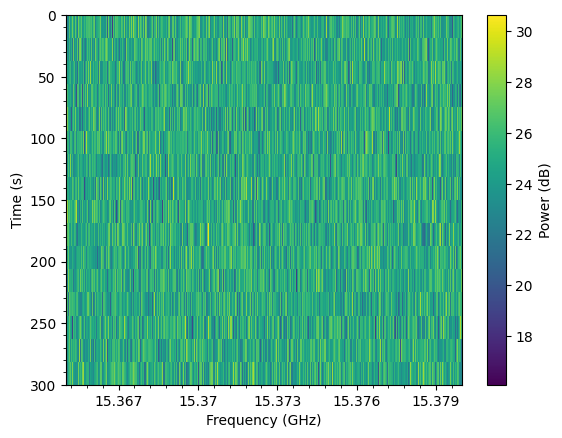

In [12]:
frame.plot('f', minor_ticks=True, db=True, funits="GHz", fdownsample=2**10)

In [13]:
def add_signal(frame, mean_freq, dr, snr, width):
    f_start = mean_freq - dr*frame.data.shape[0]*frame.dt*u.s/2
    
    return frame.add_signal(
        stg.constant_path(f_start=f_start,
                          drift_rate=dr),
        stg.constant_t_profile(level=frame.get_intensity(snr=snr)),
        stg.gaussian_f_profile(width=width),
        stg.constant_bp_profile(level=1)
    )

In [14]:
midf = 15.37*u.GHz ; dr  = 1.5 * (u.Hz/u.s);
width=1*u.Hz       ; snr = 30

In [15]:
signal = add_signal(frame, midf, dr, snr, width)

In [16]:
frame.get_index(frequency=midf)

np.int64(5592404)

In [17]:
frame_s = frame.get_slice(
    (f := frame.get_index(frequency=midf)) - WINDOW_SIZE//2,
    f + WINDOW_SIZE//2
)

In [18]:
frame_s.data.shape

(16, 1024)

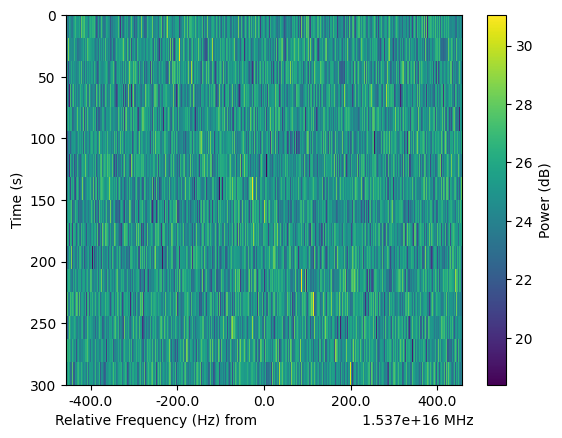

In [19]:
frame_s.plot()

In [20]:
frame.save_h5(OUTPUT_FOLDER + "meerKAT_high_30.h5")

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/meerKAT_high_30.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 3.81sec


Seticore doesn't run, but turboSETI finds the hit:

In [21]:
!seticore {OUTPUT_FOLDER+"meerKAT_high_30.h5"}

welcome to seticore, version 1.0.6
running in dedoppler mode.
loading input from ../../deliverables/injected/meerKAT_high_30.h5
dedoppler parameters: max_drift=10.00 min_drift=0.0000 snr=25.00
writing output to ../../deliverables/injected/meerKAT_high_30.dat
[2025-07-09 16:27:07 CEST] fatal exception: dataset is not float


In [22]:
!turboSETI -g y {OUTPUT_FOLDER+"meerKAT_high_30.h5"}


turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.8.0
hdf5plugin version 4.1.1
HDF5 library version 1.12.2


data_handler    INFO     From blimpy, n_coarse_chan=16
HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 15380.0, 'foff': -8.940696716308932e-07, 'ibeam': -1, 'machine_id': 20, 'nbeams': 1, 'nbits': 32, 'nchans': 16777216, 'nifs': 1, 'rawdatafile': 'Synthetic', 'source_name': 'Synthetic', 'src_dej': <Angle -28.3831 deg>, 'src_raj': <Angle 17.7875 hourangle>, 'telescope_id': 6, 'tsamp': 18.75, 'tstart': 60865.601633395745, 'za_start': 0.0}

Starting ET search with parameters: datafile=../../deliverables/injected/meerKAT_high_30.h5, max_drift=10.0, min_drift=1e-05, snr=25.0, out_dir=./, coarse_chans=, flagging=False, n_coarse_chan=16, kernels=None, gpu_id=0, gpu_backend=True, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'p